In [55]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Input, Layer, LeakyReLU
from tensorflow.keras import Model
from itertools import combinations
import datetime
# for types hints
from typing import Tuple, Callable, List, Optional
from tensorflow import Tensor
from numpy import ndarray

Synthetic Data

In [56]:
# 4 input values, each Gaussian distributed with 0 mean and 1 stdev
# 1 output value, distance from the origin, AKA L2-norm
# 1000 instances for training, 1000 for testing

In [57]:
def create_synthetic_data(n_train=1000, n_test=1000, n_features=4):
    """
    Create a synthetic regression dataset.
    The input features (X) are randomly generated using a normal distribution centered at 0 with a standard deviation of 1.
    The target values (y) are calculated as the L2 norm (Euclidean norm) of the input features.

    :param n_train: Number of training instances.
    :param n_test: Number of testing instances.
    :param n_features: Number of input features.
    :return: X_train, y_train, X_test, y_test
    """

    # Create training data
    X_train = np.random.normal(loc=0, scale=1, size=(n_train, n_features))
    y_train = np.linalg.norm(X_train, axis=1)  # Compute the L2-norm
    # Create testing data
    X_test = np.random.normal(loc=0, scale=1, size=(n_test, n_features))
    y_test = np.linalg.norm(X_test, axis=1)  # Compute the L2-norm


    return X_train, y_train, X_test, y_test

In [58]:
def normalize_labels(y: np.ndarray) -> np.ndarray:
    """
    Normalize the target values so they are between 0 and 2 using the equation:
    y' = 2 * (y - min) / (max - min)

    :param y: The original target values.
    :return: The normalized target values.
    """
    # print shape of y
    print(y.shape)
    min_val = np.min(y)
    print('min_val y in before norm: ', min_val)
    max_val = np.max(y)
    print('max_val y in before norm: ', max_val)
    
    # Normalize the labels
    normalized_y = 2 * (y - min_val) / (max_val - min_val)
    
    return normalized_y

In [59]:
# Generate the synthetic data
X_train, y_train, X_test, y_test = create_synthetic_data()
# print 5 first elements in X_train
print(X_train[:5])
# print 5 first elements in X_test
print(X_test[:5])
# print 5 first elements in y_train
print(y_train[:5])
# Normalize the labels
y_train = normalize_labels(y_train)
# print 5 first elements in y_train
print(y_train[:5])
# print 5 first elements in y_test
print(y_test[:5])
y_test = normalize_labels(y_test)
# print 5 first elements in y_test
print(y_test[:5])

[[ 0.34995899 -0.2516014  -1.26489703 -0.65340584]
 [-2.09278123  1.30210965  0.93652207 -0.02328484]
 [ 0.11060315  0.77923939  0.51568885 -1.68899125]
 [-0.07383994  0.50818245 -0.11177263 -0.38296964]
 [ 0.66191074 -0.2047816  -0.43868045 -0.54860302]]
[[-0.53181108  0.89206814  0.04473373  0.62728878]
 [-1.4981863   0.19233848 -0.43033693 -0.39608734]
 [-0.52183827  0.01356132 -1.28872915 -0.27209316]
 [-0.42414849  0.55812543  0.78549045  2.62383238]
 [ 1.07185445 -0.99309915 -0.30645138 -0.73519311]]
[1.48750739 2.63682358 1.93340982 0.65027733 0.98664439]
(1000,)
min_val y in before norm:  0.29675180386996014
max_val y in before norm:  4.546687439112961
[0.56036406 1.10122692 0.77020367 0.16636747 0.32466025]
[1.21412558 1.61976274 1.41681213 2.8271713  1.66419327]
(1000,)
min_val y in before norm:  0.23884653980972215
max_val y in before norm:  4.1471386242499175
[0.49908196 0.70665967 0.60280325 1.32452985 0.72939622]


In [60]:
# Sanity check if y values are between 0 and 2
print(f"Min y_train: {np.min(y_train)}")
print(f"Max y_train: {np.max(y_train)}")

Min y_train: 0.0
Max y_train: 2.0


Model Building

In [61]:
# NN for representation learning:
# 4 input nodes
# 1 or more hidden layers
# the last hidden layer has 2 nodes (representation layer Z)
# plot the instances in the 2D feature/representation space of Z 
# use different colors for different target values (can be in groups, each group with a different color) similar to the RankSim pictures
# training and test sets in different plots.
# expecting the instances to be in a semi-circle
# for prediction, add output layer of 1 node.


In [62]:
def create_model(hiddens: List[int]) -> Model:
    """
    Create a neural network model with two branches using the Keras functional API.
    One branch will be used for fitting the output to the label, and the other will use the Z features for the custom loss.
    The Z features are normalized to fit on the unit circle.

    :param hiddens: List of integers representing the number of nodes in each hidden layer.
    :return: The uncompiled model.
    """
    inputs = Input(shape=(4,))
    x = inputs
    # Define hidden layers according to architecture
    for nodes in hiddens:
        x = Dense(nodes)(x)
        x = LeakyReLU()(x) # Replacing 'relu' activation with LeakyReLU
    # Define the representation layer (Z features)
    repr_layer = Dense(2)(x)
    repr_layer = LeakyReLU(name='repr_layer')(repr_layer) # Replacing 'relu' activation with LeakyReLU
    # Normalize the representation layer to fit on the unit circle
    # repr_layer = Lambda(lambda z: z / tf.norm(z, axis=1, keepdims=True))(x)
    # Define the output layer for fitting to the label
    pred_output = Dense(1, name='pred_output')(repr_layer)
    # Bundle the Z features and fitting output into a model
    model = Model(inputs=inputs, outputs=[pred_output]) #, repr_layer])


    return model



In [63]:
def get_groups(y: List[float]) -> Tuple[List[int], int, int]:
    """
    Find the minimum and maximum values in the dataset and create a list of integer groups between those values.

    :param y: The target values in the dataset.
    :return: A list of integer groups between the minimum and maximum values
    :return: The minimum value in the dataset.
    :return: The maximum value in the dataset.
    """
    min_val = int(min(y))
    max_val = int(max(y))
    
    return list(range(min_val, max_val + 1)), min_val, max_val


In [64]:
def plot_feature_space(model: Model, data: ndarray, labels: ndarray, groups: Optional[List[int]] = None):
    """
    Plot the instances in the 2D feature space of the representation layer (Z).

    :param model: Trained neural network model.
    :param data: Input data, shape of [num_instances, num_features].
    :param labels: Corresponding labels for the data.
    :param groups: Optional grouping for labels to define color assignment.
    """
    # Extract the representation layer from the model
    repr_layer_model = Model(inputs=model.input, outputs=model.output)

    # Predict the representation for the input data
    repr_space = repr_layer_model.predict(data)

    # If groups are defined, categorize labels into groups
    if groups:
        group_labels = [np.digitize(label, groups) for label in labels]
    else:
        group_labels = labels

    # Create a scatter plot for the representation space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(repr_space[:, 0], repr_space[:, 1], c=group_labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('2D Feature Space of Representation Layer')
    plt.xlim(-1, 1)  # Limit x-axis to range of -1 to 1
    plt.ylim(-1, 1)  # Limit y-axis to range of -1 to 1
    plt.show()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_42 (Dense)            (None, 64)                320       
                                                                 
 leaky_re_lu_41 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_43 (Dense)            (None, 128)               8320      
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 128)               16512     
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 128)               0  

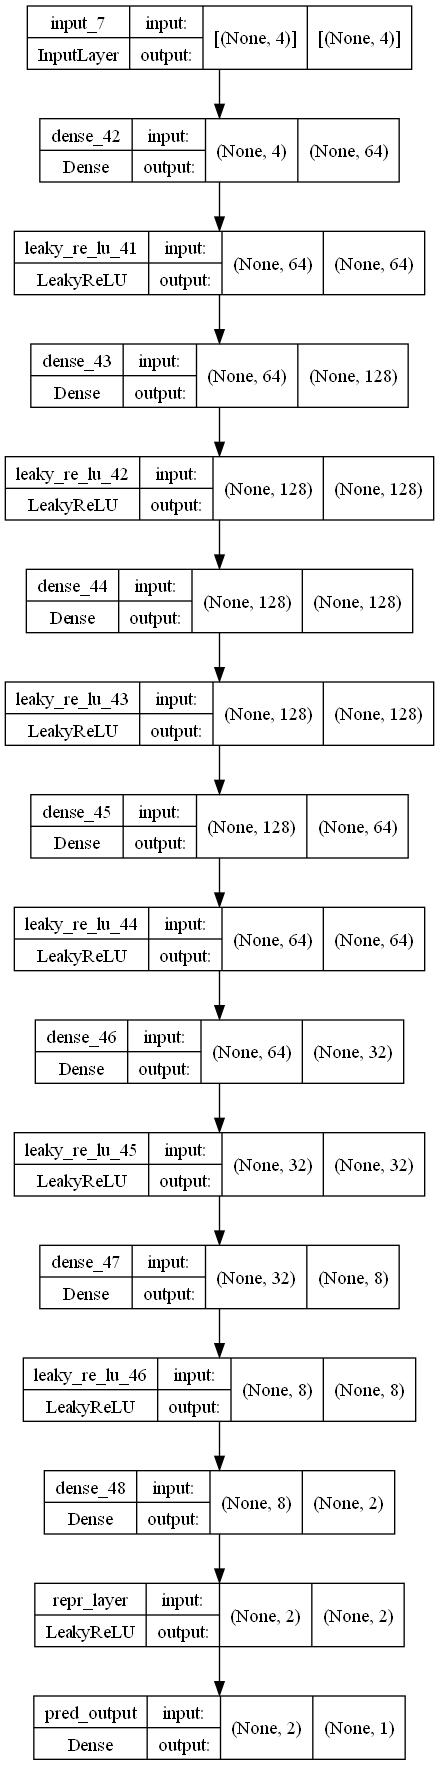

In [65]:
# Create and train the model
hiddens = [64, 128, 128, 64, 32, 8]
model = create_model(hiddens)
# summarize and plot the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [66]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# # Plot the 2D feature space
# plot_feature_space(model, X_train, y_train)
# plot_feature_space(model, X_test, y_test)

Epoch 1/10
32/32 [==============================] - 1s 6ms/step - loss: 0.2707
Epoch 2/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0188
Epoch 3/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 4/10
32/32 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 5/10
32/32 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 6/10
32/32 [==============================] - 0s 6ms/step - loss: 5.7878e-04
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 3.0166e-04
Epoch 8/10
32/32 [==============================] - 0s 6ms/step - loss: 2.3805e-04
Epoch 9/10
32/32 [==============================] - 0s 8ms/step - loss: 1.9805e-04
Epoch 10/10
32/32 [==============================] - 0s 7ms/step - loss: 1.5870e-04
Groups: [0, 1, 2, 3], Min: 0, Max: 3


Test of First Idea improving on ranksim

In [67]:
def zdist(vec1: Tensor, vec2: Tensor) -> float:
    """
    Computes the squared L2 norm distance between two input feature vectors.

    :param vec1: The first input feature vector.
    :param vec2: The second input feature vector.
    :return: The squared L2 norm distance.
    """
    return tf.reduce_sum(tf.square(vec1 - vec2))


def ydist(val1: float, val2: float) -> float:
    """
    Computes the squared distance between two label values.

    :param val1: The first label value.
    :param val2: The second label value.
    :return: The squared distance.
    """
    return (val1 - val2) ** 2

def error(z1: Tensor, z2: Tensor, label1: float, label2: float) -> float:
    """
    Computes the error between the zdist of two input predicted z values and their ydist.
    Range of the error is [0, 16].

    :param z1: The predicted z value for the first input sample.
    :param z2: The predicted z value for the second input sample.
    :param label1: The label of the first input sample.
    :param label2: The label of the second input sample.
    :return: The squared difference between the zdist and ydist.
    """
    squared_difference = (zdist(z1, z2) - ydist(label1, label2)) ** 2
    return tf.reduce_sum(squared_difference)


def custom_loss(y_true, z_pred, reduction=tf.keras.losses.Reduction.SUM):
    """
    Computes the loss for a batch of predicted features and their labels.
    
    :param y_true: A batch of true label values, shape of [batch_size, 1].
    :param z_pred: A batch of predicted Z values, shape of [batch_size, 2].
    :param reduction: The type of reduction to apply to the loss.
    :return: The average error for all unique combinations of the samples in the batch.
    """
    int_batch_size = tf.shape(z_pred)[0]
    batch_size = tf.cast(int_batch_size, dtype=tf.float32)
    total_error = tf.constant(0.0, dtype=tf.float32)

    # Loop through all unique pairs of samples in the batch
    for i in tf.range(int_batch_size):
        for j in tf.range(i + 1, int_batch_size):
            z1, z2 = z_pred[i], z_pred[j]
            # tf.print(z1, z2, sep=', ', end='\n')
            label1, label2 = y_true[i], y_true[j]
            # tf.print(label1, label2, sep=', ', end='\n')
            err = error(z1, z2, label1, label2)
            # tf.print(err, end='\n\n')
            total_error += tf.cast(err, dtype=tf.float32)
    
    # tf.print(total_error)
    
    if reduction == tf.keras.losses.Reduction.SUM:
        return total_error # total loss
    elif reduction == tf.keras.losses.Reduction.NONE:
        denom = tf.cast(batch_size * (batch_size - 1) / 2 + 1e-9, dtype=tf.float32)
        # tf.print(denom)
        return total_error / denom # average loss
    else:
        raise ValueError(f"Unsupported reduction type: {reduction}.")


In [68]:
# loss mindful sanity check
# Create a batch of 3 samples
y_true = tf.constant([[1.0], [2.0], [0.0]])
z_pred = tf.constant([[0.0, 1.0], [0.552027583, 0.833825886], [0.0, 0.0]])

# find all unique pair indices
pairs = list(combinations(range(3), 2))
print(pairs)
# compute zdist and ydist for each pair
for i, j in pairs:
    print(i, j)
    print(z_pred[i], z_pred[j])
    print(zdist(z_pred[i], z_pred[j]))
    print(y_true[i], y_true[j])
    print(ydist(y_true[i], y_true[j]))
    print(error(z_pred[i], z_pred[j], y_true[i], y_true[j]))
    
# compute the average loss
print(custom_loss(y_true, z_pred))


[(0, 1), (0, 2), (1, 2)]
0 1
tf.Tensor([0. 1.], shape=(2,), dtype=float32) tf.Tensor([0.5520276 0.8338259], shape=(2,), dtype=float32)
tf.Tensor(0.3323483, shape=(), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([2.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor(0.44575882, shape=(), dtype=float32)
0 2
tf.Tensor([0. 1.], shape=(2,), dtype=float32) tf.Tensor([0. 0.], shape=(2,), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
1 2
tf.Tensor([0.5520276 0.8338259], shape=(2,), dtype=float32) tf.Tensor([0. 0.], shape=(2,), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor([2.], shape=(1,), dtype=float32) tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([4.], shape=(1,), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(9.445759,

In [69]:
class NormalizeLayer(Layer):
    def __init__(self, epsilon: float = 1e-9, **kwargs):
        """
        Initialization for the NormalizeLayer.

        :param epsilon: A small constant to prevent division by zero during normalization. Default is 1e-9.
        :param kwargs: Additional keyword arguments for the parent class.
        """
        self.epsilon = epsilon
        super(NormalizeLayer, self).__init__(**kwargs)

    def call(self, inputs: Tensor) -> Tensor:
        """
        Forward pass for the NormalizeLayer.

        :param inputs: Input tensor of shape [batch_size, ...].
        :return: Normalized input tensor of the same shape as inputs.
        """
        norm = tf.norm(inputs, axis=1, keepdims=True) + self.epsilon
        return inputs / norm

    def get_config(self) -> dict:
        """
        Returns the config of the layer. Contains the layer's configuration as a dict,
        including the `epsilon` parameter and the configurations of the parent class.

        :return: A dict containing the layer's configuration.
        """
        config = super().get_config()
        config.update({
            "epsilon": self.epsilon,
        })
        return config


In [70]:
def create_model_feat(hiddens: List[int]) -> Model:
    """
    Create a neural network model with two branches using the Keras functional API.
    One branch will be used for fitting the output to the label, and the other will use the Z features for the custom loss.
    The Z features are normalized to fit on the unit circle.

    :param hiddens: List of integers representing the number of nodes in each hidden layer.
    :return: The uncompiled model.
    """
    inputs = Input(shape=(4,))
    x = inputs
    # Define hidden layers according to architecture
    for nodes in hiddens:
        x = Dense(nodes)(x)
        x = LeakyReLU()(x)
     # Define the representation layer (Z features)
    x = Dense(2)(x)
    x = LeakyReLU()(x)
    # Normalize the representation layer to fit on the unit circle
    repr_layer = NormalizeLayer()(x)
    # Bundle the Z features and fitting output into a model
    enc_model = Model(inputs=inputs, outputs=repr_layer)

    return enc_model


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_49 (Dense)            (None, 64)                320       
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 64)                0         
                                                                 
 dense_50 (Dense)            (None, 128)               8320      
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 128)               0         
                                                                 
 dense_51 (Dense)            (None, 128)               16512     
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 128)               0  

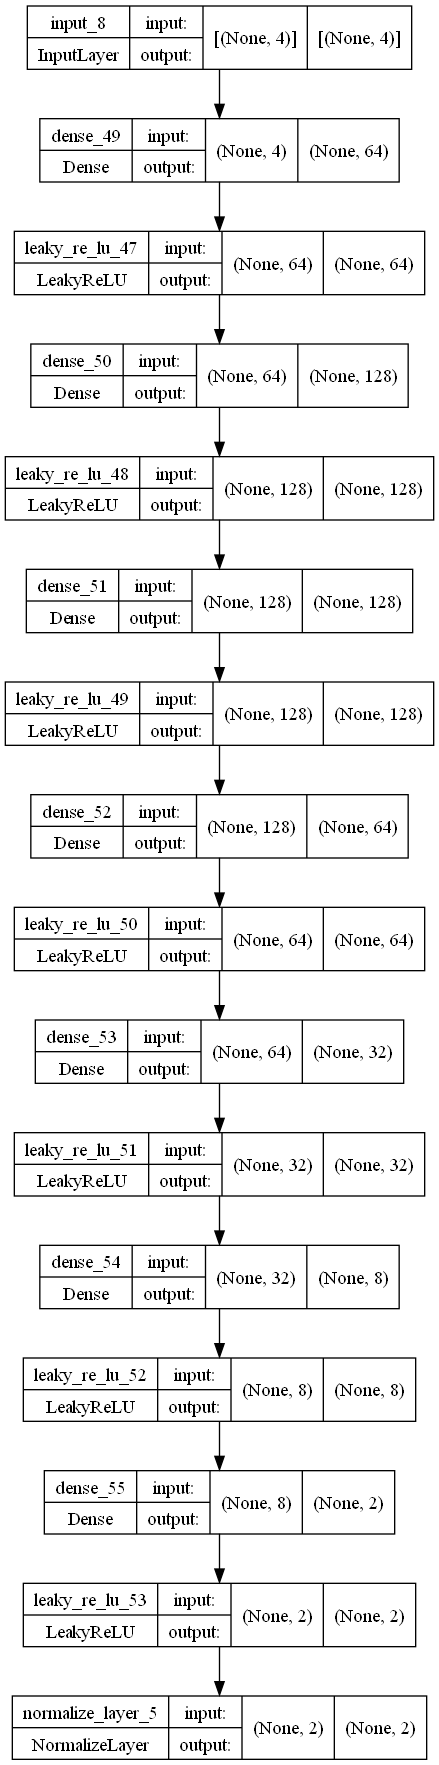

In [71]:
# Create and train the model
model_feat = create_model_feat(hiddens)
# summarize and plot the model
model_feat.summary()
tf.keras.utils.plot_model(model_feat, show_shapes=True)

In [72]:
model_feat.compile(optimizer='adam', loss=custom_loss)

[0.9999999  0.99999994 1.         1.0000001 ]


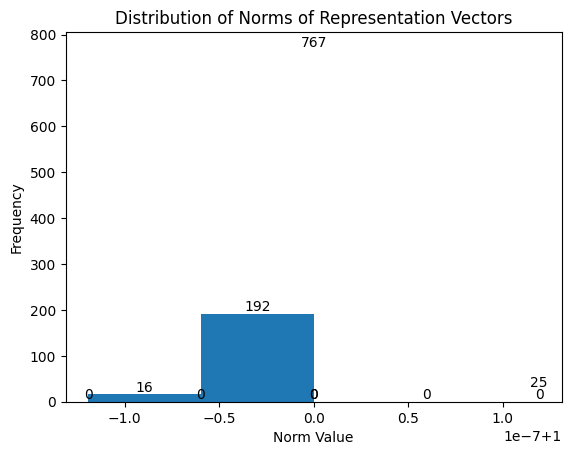

In [73]:
# mindful sanity check of the model output being normalized
reprs = model_feat.predict(X_train)
# Calculate the norms of the representation vectors
norms = np.linalg.norm(reprs, axis=1)
# Find all unique norm values
unique_norms = np.unique(norms)
# Print or otherwise use the unique norm values
print(unique_norms)
# Plot a histogram of the norms and get the patches to annotate
n, bins, patches = plt.hist(norms)

# Iterate through the patches to annotate each bar
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, 
             patches[i].get_height(), 
             str(int(n[i])),
             ha='center', 
             va='bottom')
plt.title('Distribution of Norms of Representation Vectors')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.show()



In [74]:
# setup tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
# tensorboard --logdir logs/fit

In [75]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss)
history = model_feat.fit(X_train, y_train, epochs=400, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])  

Epoch 1/400
50/50 [==============================] - 10s 161ms/step - loss: 15.4831 - val_loss: 14.8769
Epoch 2/400
50/50 [==============================] - 9s 173ms/step - loss: 13.0243 - val_loss: 13.7655
Epoch 3/400
50/50 [==============================] - 8s 168ms/step - loss: 13.0614 - val_loss: 14.1159
Epoch 4/400
50/50 [==============================] - 8s 159ms/step - loss: 13.5397 - val_loss: 13.3412
Epoch 5/400
50/50 [==============================] - 8s 163ms/step - loss: 11.1746 - val_loss: 6.4313
Epoch 6/400
50/50 [==============================] - 7s 145ms/step - loss: 4.0029 - val_loss: 4.1524
Epoch 7/400
50/50 [==============================] - 7s 141ms/step - loss: 3.2126 - val_loss: 2.4287
Epoch 8/400
50/50 [==============================] - 7s 141ms/step - loss: 2.1594 - val_loss: 4.0153
Epoch 9/400
50/50 [==============================] - 7s 138ms/step - loss: 1.8971 - val_loss: 1.6309
Epoch 10/400
50/50 [==============================] - 7s 142ms/step - loss: 0.826

Groups: [0, 1, 2], Min: 0, Max: 2


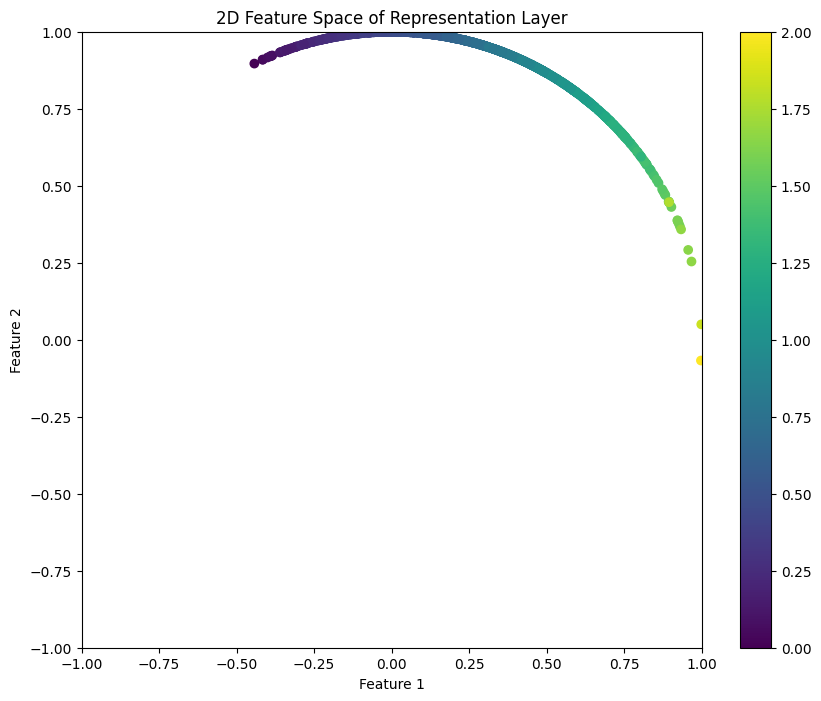

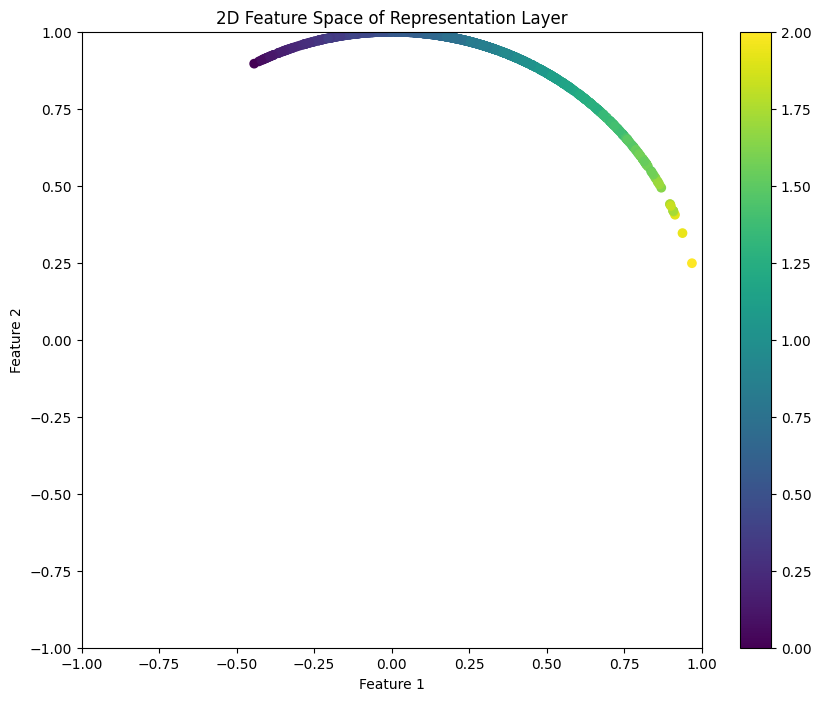

In [78]:
# get groupings for the labels
y_concatenated = np.concatenate([y_train, y_test], axis=0)
groups, min_val, max_val = get_groups(y_concatenated)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat, X_train, y_train)
plot_feature_space(model_feat, X_test, y_test)

In [79]:
# finetuning with lower learning rate
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss=custom_loss)
history = model_feat.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/200
50/50 [==============================] - 10s 161ms/step - loss: 0.1005 - val_loss: 0.3476
Epoch 2/200
50/50 [==============================] - 9s 174ms/step - loss: 0.0738 - val_loss: 0.3445
Epoch 3/200
50/50 [==============================] - 8s 150ms/step - loss: 0.0880 - val_loss: 0.3418
Epoch 4/200
50/50 [==============================] - 8s 152ms/step - loss: 0.0695 - val_loss: 0.3409
Epoch 5/200
50/50 [==============================] - 7s 147ms/step - loss: 0.0705 - val_loss: 0.3380
Epoch 6/200
50/50 [==============================] - 7s 145ms/step - loss: 0.0718 - val_loss: 0.3379
Epoch 7/200
50/50 [==============================] - 7s 145ms/step - loss: 0.0684 - val_loss: 0.3350
Epoch 8/200
50/50 [==============================] - 8s 160ms/step - loss: 0.0810 - val_loss: 0.3341
Epoch 9/200
50/50 [==============================] - 8s 152ms/step - loss: 0.0770 - val_loss: 0.3320
Epoch 10/200
50/50 [==============================] - 8s 153ms/step - loss: 0.0703 - val_l

Groups: [0, 1, 2], Min: 0, Max: 2


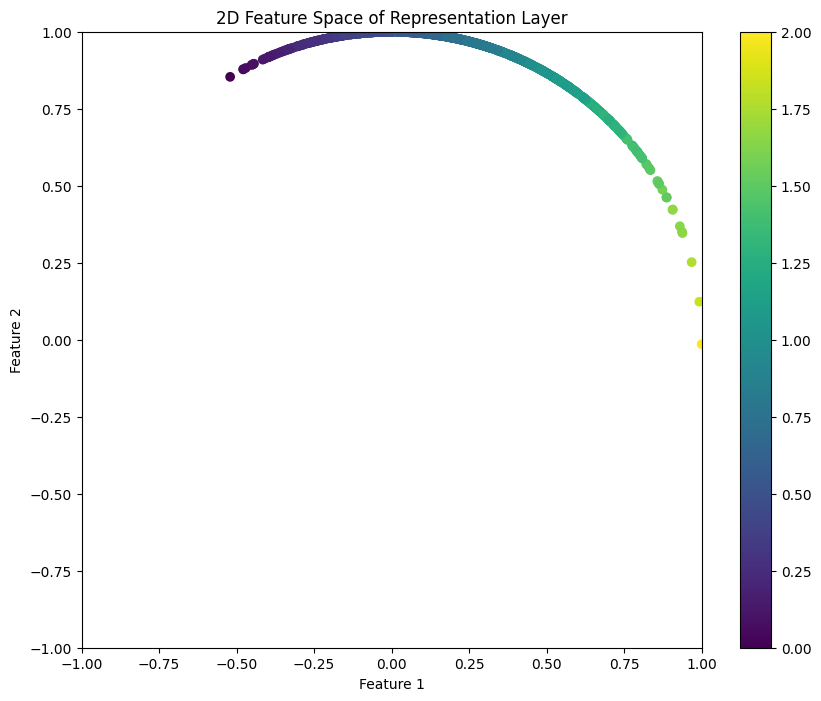

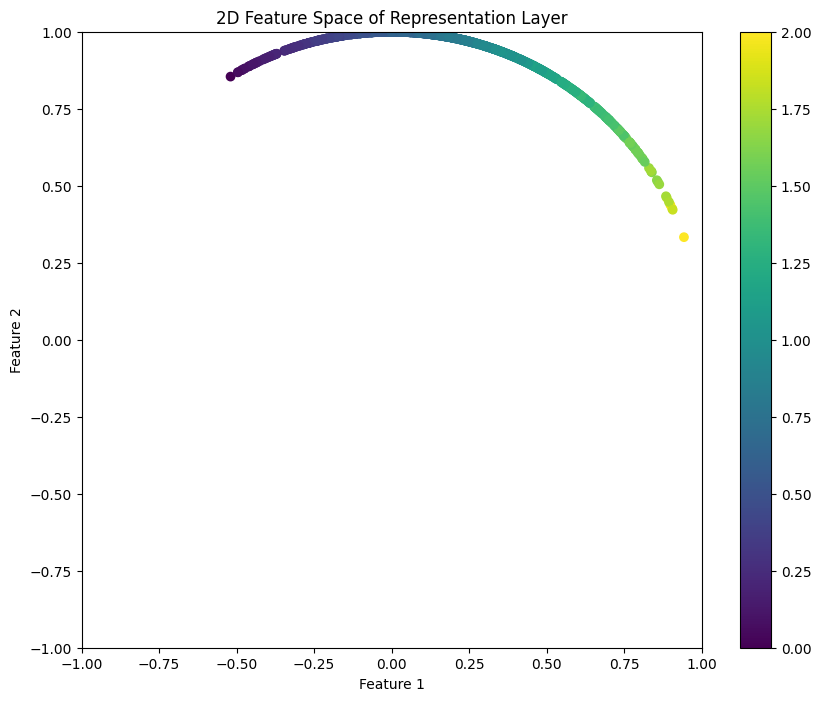

In [82]:
# get groupings for the labels
y_concatenated = np.concatenate([y_train, y_test], axis=0)
groups, min_val, max_val = get_groups(y_concatenated)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat, X_train, y_train)
plot_feature_space(model_feat, X_test, y_test)

In [ ]:
# model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss=custom_loss)
# history = model_feat.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=[tensorboard_cb])

In [ ]:
# get groupings for the labels
# y_concatenated = np.concatenate([y_train, y_test], axis=0)
# groups, min_val, max_val = get_groups(y_concatenated)
# print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# # Plot the 2D feature space
# plot_feature_space(model_feat, X_train, y_train)
# plot_feature_space(model_feat, X_test, y_test)


In [83]:
# Find the indices of the 10 smallest values in y_train
indices_of_smallest = np.argsort(y_test)[:10]

# Print the inputs, features, and target values for the 10 instances
for index in indices_of_smallest:
    print("Inputs:", X_test[index])
    print("Target Value:", y_test[index])
    print("Feature Value:", model_feat.predict(X_test[index:index+1])) 
    print("---")


Inputs: [ 0.16403645 -0.05868467  0.14490945  0.07547895]
Target Value: 0.0
Feature Value: [[-0.5197596  0.8543126]]
---
Inputs: [-0.19330486 -0.17943877  0.020779   -0.20353642]
Target Value: 0.04859187403538889
Feature Value: [[-0.49623516  0.8681882 ]]
---
Inputs: [ 0.1998497   0.12304422 -0.25946234 -0.07212858]
Target Value: 0.06057332109548724
Feature Value: [[-0.4833785   0.87541145]]
---
Inputs: [-0.24029188  0.15503322 -0.21775669  0.0503556 ]
Target Value: 0.06350526848205516
Feature Value: [[-0.48377958  0.87518984]]
---
Inputs: [ 0.21116286  0.05637075 -0.1670919  -0.24213027]
Target Value: 0.06531879193151877
Feature Value: [[-0.49534795  0.8686946 ]]
---
Inputs: [-0.12318392 -0.16783971  0.3212471   0.12085472]
Target Value: 0.08320176465397873
Feature Value: [[-0.47402206  0.880513  ]]
---
Inputs: [ 0.20250014  0.01681318 -0.10916066  0.34129026]
Target Value: 0.08857103393226957
Feature Value: [[-0.46142522  0.88717914]]
---
Inputs: [ 0.32059093 -0.19412278  0.11509097 

In [84]:
# Find the indices of the 10 largest values in y_test
indices_of_largest = np.argsort(y_test)[-10:]

# Print the inputs, features, and target values for the 10 instances
for index in indices_of_largest:
    print("Inputs:", X_test[index])
    print("Target Value:", y_test[index])
    print("Feature Value:", model_feat.predict(X_test[index:index+1])) 
    print("---")


Inputs: [-0.66166039 -1.61995567 -1.06960583  2.88804315]
Target Value: 1.6904130218645055
Feature Value: [[0.8633523  0.50460166]]
---
Inputs: [-2.91257518  1.73507251  0.45326313  0.9587324 ]
Target Value: 1.6955549929842646
Feature Value: [[0.82978034 0.55809   ]]
---
Inputs: [-0.85118267  2.15820617  2.4051415   1.33724711]
Target Value: 1.719677408170317
Feature Value: [[0.8365724  0.54785645]]
---
Inputs: [-2.25891844  1.12559813 -0.86486169 -2.44761518]
Target Value: 1.730535070717517
Feature Value: [[0.8849439  0.46569756]]
---
Inputs: [ 2.4128958  -2.19341696 -1.03374832 -1.29864882]
Target Value: 1.7502027344386148
Feature Value: [[0.8944102 0.4472477]]
---
Inputs: [-0.1723927   0.21030117  1.94944472  3.22703691]
Target Value: 1.812099399331439
Feature Value: [[0.88738674 0.46102586]]
---
Inputs: [ 2.31641503 -1.30201463 -1.72802956  2.121885  ]
Target Value: 1.8297171438583253
Feature Value: [[0.9065625  0.42207146]]
---
Inputs: [-2.18439182  2.06790111 -1.68644684  1.98027

In [85]:
# let's find the count per bins 
def count_samples_in_bins(y_values: ndarray):
    """
    Count the number of samples whose target values are in bins.
    The bins are defined by intervals of 0.1 from 0 to 2.

    :param y_values: A numpy array containing target values.
    :return: None, but prints the count per bin along with the range of the bin.
    """
    # Define the bins
    bins = np.arange(0, 2.1, 0.1)
    
    # Count the samples in each bin
    hist, _ = np.histogram(y_values, bins)
    
    # Output the count and range for each bin
    for i in range(len(bins) - 1):
        print(f"Bin {i} ({bins[i]:.1f} to {bins[i+1]:.1f}): {hist[i]} samples")

In [86]:
# Count the samples in each bin for the test set
count_samples_in_bins(y_test)
# This confirms that the test set is normally distributed around .9 where 
# both values very close to 0 and 2 are very rare so they are separated in feature space
# Why values close to zero are as rare?
# when considering the standard gaussian density function,
# to have a norm close to zero, you need to have all 4 features close to zero
# which means the interval over which the density function is integrated is very small
# the bins reflect that.

Bin 0 (0.0 to 0.1): 9 samples
Bin 1 (0.1 to 0.2): 19 samples
Bin 2 (0.2 to 0.3): 26 samples
Bin 3 (0.3 to 0.4): 53 samples
Bin 4 (0.4 to 0.5): 81 samples
Bin 5 (0.5 to 0.6): 96 samples
Bin 6 (0.6 to 0.7): 113 samples
Bin 7 (0.7 to 0.8): 120 samples
Bin 8 (0.8 to 0.9): 114 samples
Bin 9 (0.9 to 1.0): 79 samples
Bin 10 (1.0 to 1.1): 64 samples
Bin 11 (1.1 to 1.2): 71 samples
Bin 12 (1.2 to 1.3): 46 samples
Bin 13 (1.3 to 1.4): 41 samples
Bin 14 (1.4 to 1.5): 25 samples
Bin 15 (1.5 to 1.6): 27 samples
Bin 16 (1.6 to 1.7): 8 samples
Bin 17 (1.7 to 1.8): 3 samples
Bin 18 (1.8 to 1.9): 2 samples
Bin 19 (1.9 to 2.0): 3 samples


In [87]:
# Count the samples in each bin for the training set
count_samples_in_bins(y_train)

Bin 0 (0.0 to 0.1): 8 samples
Bin 1 (0.1 to 0.2): 24 samples
Bin 2 (0.2 to 0.3): 47 samples
Bin 3 (0.3 to 0.4): 65 samples
Bin 4 (0.4 to 0.5): 92 samples
Bin 5 (0.5 to 0.6): 106 samples
Bin 6 (0.6 to 0.7): 116 samples
Bin 7 (0.7 to 0.8): 109 samples
Bin 8 (0.8 to 0.9): 108 samples
Bin 9 (0.9 to 1.0): 98 samples
Bin 10 (1.0 to 1.1): 72 samples
Bin 11 (1.1 to 1.2): 54 samples
Bin 12 (1.2 to 1.3): 46 samples
Bin 13 (1.3 to 1.4): 27 samples
Bin 14 (1.4 to 1.5): 12 samples
Bin 15 (1.5 to 1.6): 9 samples
Bin 16 (1.6 to 1.7): 4 samples
Bin 17 (1.7 to 1.8): 1 samples
Bin 18 (1.8 to 1.9): 1 samples
Bin 19 (1.9 to 2.0): 1 samples


In [88]:
# why are the green and yellow points mixed up?
# mixup happens mostly for large values of y (close to 2), rare samples
# no mixup in training set feature space but mixup in test set feature space for rare samples
# this might be due to imbalance for rare sample
# TODO: test it with balanced dataset

In [97]:
# def augment_data(X: np.ndarray, y: np.ndarray, threshold: float=1.5, n_augment: int=500) -> Tuple[np.ndarray, np.ndarray]:
#     """
#     Augment the dataset by generating synthetic points interpolated between existing points 
#     with L2 norm > threshold. More samples will be generated closer to 2 than to the threshold.
# 
#     :param X: Input features, shape [n_samples, n_features].
#     :param y: Target values, shape [n_samples].
#     :param threshold: L2 norm threshold for identifying rare samples to augment.
#     :param n_augment: Number of synthetic points to generate.
#     :return: Augmented dataset (X_augmented, y_augmented).
#     """
#     # Identify indices of points with L2 norm greater than the threshold
#     high_norm_indices = np.where(y > threshold)[0]
#     high_norm_values = y[high_norm_indices]
#     
#     # Calculate selection probabilities proportional to distance from the threshold
#     selection_probabilities = high_norm_values - threshold
#     selection_probabilities /= selection_probabilities.sum()
# 
#     # Initialize lists to store augmented data
#     X_augment = []
#     y_augment = []
# 
#     # Generate synthetic points
#     for _ in range(n_augment):
#         # Randomly choose two data points from the high_norm_indices, weighted by selection_probabilities
#         idx1, idx2 = np.random.choice(high_norm_indices, 2, replace=False, p=selection_probabilities)
# 
#         # Generate a random interpolation factor
#         alpha = np.random.rand()
# 
#         # Create synthetic point and corresponding label
#         x_new = alpha * X[idx1] + (1 - alpha) * X[idx2]
#         y_new = alpha * y[idx1] + (1 - alpha) * y[idx2]
# 
#         X_augment.append(x_new)
#         y_augment.append(y_new)
# 
#     # Convert lists to NumPy arrays
#     X_augment = np.array(X_augment)
#     y_augment = np.array(y_augment)
# 
#     # Combine original and augmented data
#     X_augmented = np.vstack((X, X_augment))
#     y_augmented = np.hstack((y, y_augment))
# 
#     return X_augmented, y_augmented

In [ ]:
# def augment_data_by_perturbation(X: np.ndarray, y: np.ndarray, threshold: float=1.5, upper_bound: float=2.0, n_augment: int=500, perturbation_scale: float=0.1) -> Tuple[np.ndarray, np.ndarray]:
#     """
#     Augment the dataset by generating synthetic points through random perturbations of existing points
#     with L2 norm > threshold. More samples will be generated closer to an upper bound.
# 
#     :param X: Input features, shape [n_samples, n_features].
#     :param y: Target values, shape [n_samples].
#     :param threshold: L2 norm threshold for identifying rare samples to augment.
#     :param upper_bound: The upper bound to which generated samples should be closer.
#     :param n_augment: Number of synthetic points to generate.
#     :param perturbation_scale: Scale factor for random perturbations.
#     :return: Augmented dataset (X_augmented, y_augmented).
#     """
#     # Identify indices of points with L2 norm greater than the threshold
#     high_norm_indices = np.where(y > threshold)[0]
#     
#     # Calculate weights: the closer the sample is to the upper_bound, the higher the weight.
#     weights = np.abs(y[high_norm_indices] - upper_bound)
#     weights = 1 / np.maximum(weights, 1e-8)  # avoid division by zero
#     weights /= np.sum(weights)  # normalize weights
#     
#     # Initialize lists to store augmented data
#     X_augment = []
#     y_augment = []
# 
#     # Generate synthetic points
#     for _ in range(n_augment):
#         # Weighted random choice of a data point from high_norm_indices
#         idx = np.random.choice(high_norm_indices, 1, p=weights)[0]
# 
#         # Generate a random perturbation
#         perturbation = np.random.normal(scale=perturbation_scale, size=X[idx].shape)
# 
#         # Create perturbed point
#         x_new = X[idx] + perturbation
# 
#         # Calculate its corresponding y value (L2 norm)
#         y_new = np.linalg.norm(x_new)
# 
#         X_augment.append(x_new)
#         y_augment.append(y_new)
# 
#     # Convert lists to NumPy arrays
#     X_augment = np.array(X_augment)
#     y_augment = np.array(y_augment)
#     
#     # Normalize the augmented labels
#     y_augment = normalize_labels(y_augment)
# 
#     # Combine original and augmented data
#     X_augmented = np.vstack((X, X_augment))
#     y_augmented = np.hstack((y, y_augment))
# 
#     return X_augmented, y_augmented

In [144]:
def augment_data(X: np.ndarray, y: np.ndarray, threshold: float=1.5, n_augment: int=500, perturbation_scale: float=0.05) -> Tuple[np.ndarray, np.ndarray]:
    """
    Augment the dataset by generating synthetic points through random perturbations of existing points
    with L2 norm > threshold.

    :param X: Input features, shape [n_samples, n_features].
    :param y: Target values, shape [n_samples].
    :param threshold: L2 norm threshold for identifying rare samples to augment.
    :param n_augment: Number of synthetic points to generate.
    :param perturbation_scale: Scale factor for random perturbations.
    :return: Augmented dataset (X_augmented, y_augmented).
    """
    # Identify indices of points with L2 norm greater than the threshold
    high_norm_indices = np.where(y > threshold)[0]
    
    # Initialize lists to store augmented data
    X_augment = []
    y_augment = []

    # Generate synthetic points
    for _ in range(n_augment):
        # Randomly choose a data point from the high_norm_indices
        idx = np.random.choice(high_norm_indices, 1)[0]

        # Generate a random perturbation
        perturbation = np.random.normal(scale=perturbation_scale, size=X[idx].shape)

        # Create perturbed point
        x_new = X[idx] + perturbation

        # Calculate its corresponding y value (L2 norm)
        y_new = np.linalg.norm(x_new)

        X_augment.append(x_new)
        y_augment.append(y_new)

    # Convert lists to NumPy arrays
    X_augment = np.array(X_augment)
    y_augment = np.array(y_augment)
    
    # Normalize the augmented labels
    y_augment = normalize_labels(y_augment)

    # Combine original and augmented data
    X_augmented = np.vstack((X, X_augment))
    y_augmented = np.hstack((y, y_augment))

    return X_augmented, y_augmented

In [149]:
X_train_aug, y_train_aug = augment_data(X_train, y_train, threshold=1.8, n_augment=500)
# printing number of elements in X_train_aug, y_train_aug
print(len(X_train_aug), len(y_train_aug))
# counting samples in bins for augmented data
count_samples_in_bins(y_train_aug)
# printing min and max values in y_train_aug
print(f"Min y_train_aug: {np.min(y_train_aug)}")
print(f"Max y_train_aug: {np.max(y_train_aug)}")

(500,)
min_val y in before norm:  4.083376976188091
max_val y in before norm:  4.663111408294887
1500 1500
Bin 0 (0.0 to 0.1): 9 samples
Bin 1 (0.1 to 0.2): 35 samples
Bin 2 (0.2 to 0.3): 71 samples
Bin 3 (0.3 to 0.4): 114 samples
Bin 4 (0.4 to 0.5): 142 samples
Bin 5 (0.5 to 0.6): 158 samples
Bin 6 (0.6 to 0.7): 142 samples
Bin 7 (0.7 to 0.8): 124 samples
Bin 8 (0.8 to 0.9): 109 samples
Bin 9 (0.9 to 1.0): 98 samples
Bin 10 (1.0 to 1.1): 73 samples
Bin 11 (1.1 to 1.2): 55 samples
Bin 12 (1.2 to 1.3): 54 samples
Bin 13 (1.3 to 1.4): 45 samples
Bin 14 (1.4 to 1.5): 60 samples
Bin 15 (1.5 to 1.6): 71 samples
Bin 16 (1.6 to 1.7): 60 samples
Bin 17 (1.7 to 1.8): 41 samples
Bin 18 (1.8 to 1.9): 26 samples
Bin 19 (1.9 to 2.0): 13 samples
Min y_train_aug: 0.0
Max y_train_aug: 2.0


In [152]:
# Create and train the model
model_feat_aug = create_model_feat(hiddens)
model_feat_aug.compile(optimizer='adam', loss=custom_loss)

In [153]:
# setup tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [154]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
model_feat_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss)
history = model_feat_aug.fit(X_train_aug, y_train_aug, epochs=400, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb]) 

Epoch 1/400
75/75 [==============================] - 16s 183ms/step - loss: 25.4136 - val_loss: 64.9632
Epoch 2/400
75/75 [==============================] - 13s 174ms/step - loss: 17.7697 - val_loss: 53.8451
Epoch 3/400
75/75 [==============================] - 12s 166ms/step - loss: 10.8763 - val_loss: 19.8093
Epoch 4/400
75/75 [==============================] - 12s 162ms/step - loss: 7.9223 - val_loss: 24.3366
Epoch 5/400
75/75 [==============================] - 12s 157ms/step - loss: 6.1683 - val_loss: 15.6315
Epoch 6/400
75/75 [==============================] - 12s 160ms/step - loss: 6.3623 - val_loss: 19.2531
Epoch 7/400
75/75 [==============================] - 12s 158ms/step - loss: 5.1120 - val_loss: 15.0520
Epoch 8/400
75/75 [==============================] - 12s 163ms/step - loss: 5.5332 - val_loss: 14.9569
Epoch 9/400
75/75 [==============================] - 12s 165ms/step - loss: 5.4943 - val_loss: 16.2026
Epoch 10/400
75/75 [==============================] - 12s 163ms/step -

Groups: [0, 1, 2], Min: 0, Max: 2


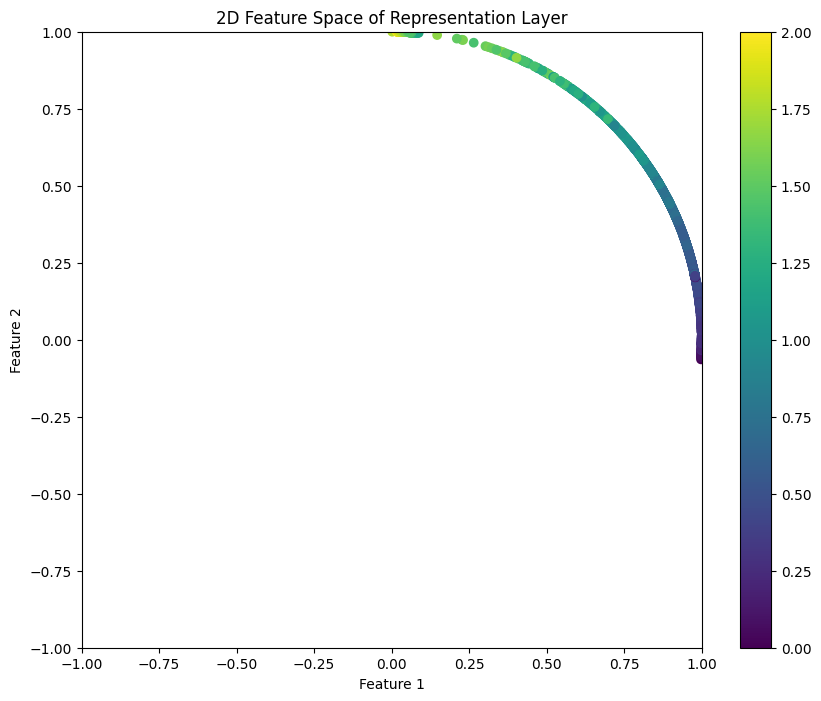

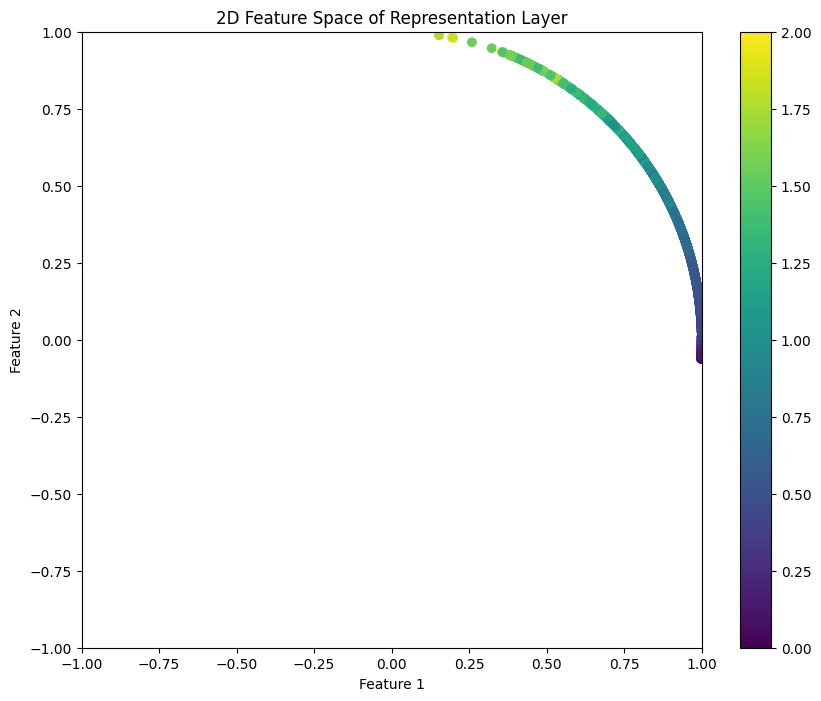

In [155]:
# get groupings for the labels
y_concatenated = np.concatenate([y_train_aug, y_test], axis=0)
groups, min_val, max_val = get_groups(y_concatenated)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat_aug, X_train_aug, y_train_aug)
plot_feature_space(model_feat_aug, X_test, y_test)

In [110]:
# finetuning with lower learning rate
model_feat_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss=custom_loss)
history = model_feat_aug.fit(X_train_aug, y_train_aug, epochs=200, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/200
60/60 [==============================] - 11s 147ms/step - loss: 1.1193 - val_loss: 0.8906
Epoch 2/200
60/60 [==============================] - 9s 144ms/step - loss: 1.0516 - val_loss: 0.8836
Epoch 3/200
60/60 [==============================] - 8s 140ms/step - loss: 1.0098 - val_loss: 0.8766
Epoch 4/200
60/60 [==============================] - 8s 134ms/step - loss: 1.1113 - val_loss: 0.8714
Epoch 5/200
60/60 [==============================] - 9s 147ms/step - loss: 0.9513 - val_loss: 0.8678
Epoch 6/200
60/60 [==============================] - 9s 146ms/step - loss: 0.9128 - val_loss: 0.8613
Epoch 7/200
60/60 [==============================] - 9s 147ms/step - loss: 0.9686 - val_loss: 0.8583
Epoch 8/200
60/60 [==============================] - 9s 146ms/step - loss: 0.8955 - val_loss: 0.8503
Epoch 9/200
60/60 [==============================] - 8s 140ms/step - loss: 0.9465 - val_loss: 0.8474
Epoch 10/200
60/60 [==============================] - 9s 156ms/step - loss: 0.9253 - val_l

Groups: [0, 1, 2], Min: 0, Max: 2


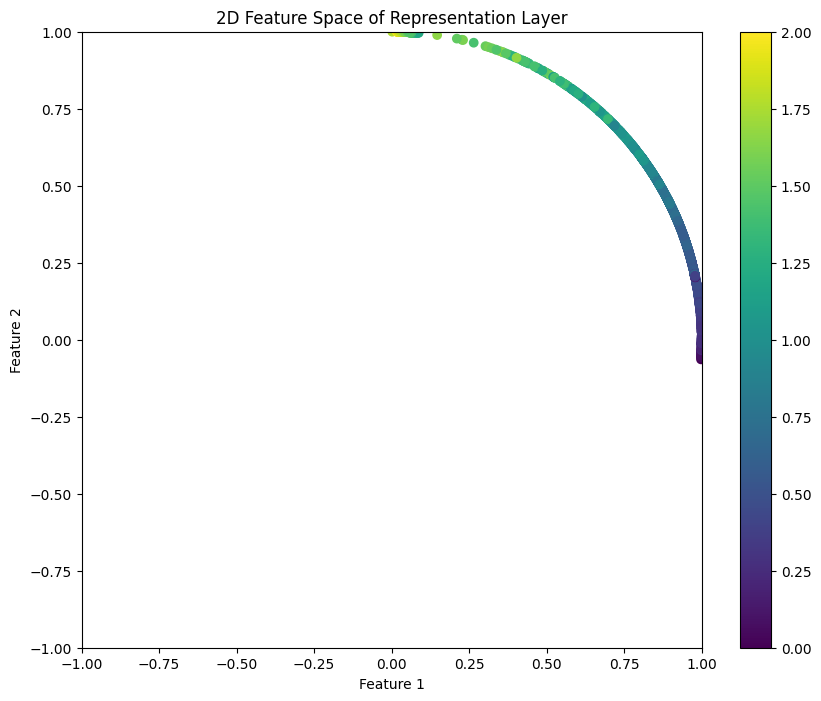

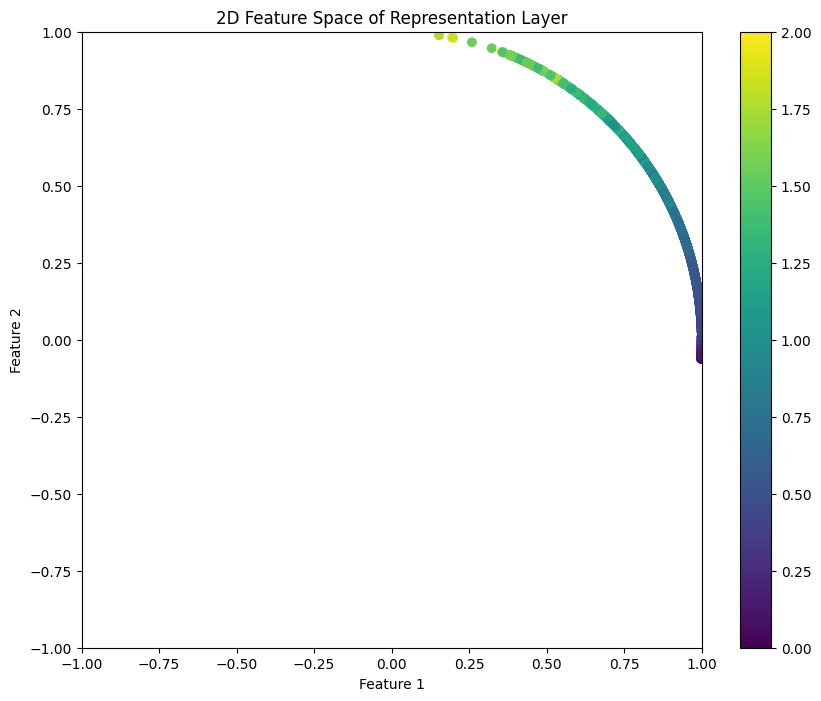

In [156]:
# get groupings for the labels
y_concatenated = np.concatenate([y_train_aug, y_test], axis=0)
groups, min_val, max_val = get_groups(y_concatenated)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat_aug, X_train_aug, y_train_aug)
plot_feature_space(model_feat_aug, X_test, y_test)